# Running Lagrangian Perturbation Theory simulation

Build Gaussian initial conditions, run first-order LPT, paint flat/spherical maps, and inspect spectra using the library plot helpers.


## Environment Setup

Configure JAX memory allocation and import required libraries:

In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.97'

import jax
import jax.numpy as jnp
import jax_cosmo as jc
import matplotlib.pyplot as plt

from fwd_model_tools import (
    gaussian_initial_conditions,
    lpt,
    PaintingOptions,
    compute_lightcone_shells,
    Planck18,
    PositionUnit,
)

/home/wassim/Projects/NBody/jax_cosmo/jax_cosmo/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/home/wassim/micromamba/envs/ffi11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SyntaxError: '(' was never closed (interp.py, line 182)

## Simulation Parameters

Define the simulation box and map resolutions:
- `mesh_size`: 3D grid resolution for the density field
- `box_size`: Physical size of the simulation box in Mpc/h
- `nside`: HEALPix resolution for spherical maps
- `flatsky_npix`, `flat_field_size`: Flat-sky map dimensions and angular extent

In [2]:
# Tiny configuration for speed
key = jax.random.PRNGKey(0)
mesh_size = (64 , 64 , 64)
box_size = (2000.0, 2000.0, 2000.0)
nside = 512 
flatsky_npix = (512, 512)
flat_field_size = (10, 10)
cosmo = Planck18()

## Gaussian Initial Conditions

Generate a Gaussian random field with the matter power spectrum as the target covariance. This field represents primordial density fluctuations that will be evolved using perturbation theory.

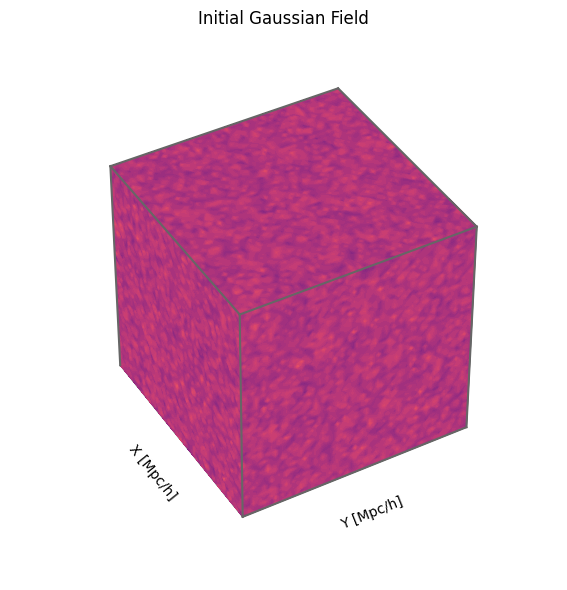

In [3]:
# 1) Gaussian initial field (pk_fn left None to use default)
initial_field = gaussian_initial_conditions(
    key, mesh_size, box_size, cosmo=cosmo, nside=nside, flatsky_npix=flatsky_npix, field_size=flat_field_size
)
initial_field.show(labels=["X [Mpc/h]", "Y [Mpc/h]", ""] , colorbar=False , titles=["Initial Gaussian Field"])

## Lightcone Shell Configuration

Compute the radial distances and scale factors for discrete redshift shells that tile the lightcone. These shells define the output snapshots for the LPT simulation.

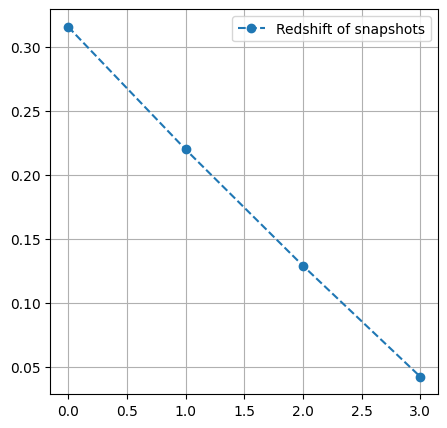

In [4]:
r_center , a_center = compute_lightcone_shells(cosmo , initial_field , 4)
z_center = jc.utils.a2z(a_center)
fig  = plt.figure(figsize=(5 , 5))
plt.plot(z_center , label='Redshift of snapshots' ,linestyle='--', marker='o')
plt.grid(True)
plt.legend()
plt.show()

## Lagrangian Perturbation Theory Simulation

First-order LPT (Zel'dovich approximation) displaces particles from their initial Lagrangian positions **q** to Eulerian positions **x**:

$$\mathbf{x}(a) = \mathbf{q} + D(a)\,\boldsymbol{\Psi}(\mathbf{q})$$

where $D(a)$ is the linear growth factor and $\boldsymbol{\Psi}$ is the displacement field derived from the gravitational potential.

`scale_factor_spec` parameter can be one of:
- **Scalar**: single scale factor, in this case only geometry allowed is **Particles**
- **Array**: array of scale factors, in this it used as center scale factors for lightcone shells
- **2D Array**: 2D array of shape (n_shells, 2) defining near and far scale factors for each shell

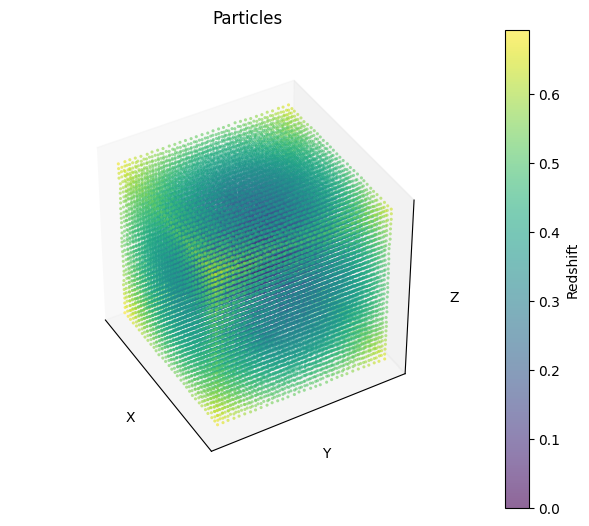

In [9]:
ptcl, _ = lpt(cosmo, initial_field, scale_factor_spec=a_center, order=1)
ptcl.to(PositionUnit.GRID_ABSOLUTE).show(thinning=2, weights="redshift")

# Getting densities out of the particle field

We can also get density such as a 3D Density or shells (flat or spherical) by choosing the correct painting options

In [10]:
spherical_dens, _ = lpt(cosmo, initial_field, scale_factor_spec=a_center, order=1, painting=PaintingOptions(target="spherical", scheme="bilinear"))
flat_dens, _ = lpt(cosmo, initial_field, scale_factor_spec=a_center, order=1, painting=PaintingOptions(target="flat"))
density3d, _ = lpt(cosmo, initial_field, scale_factor_spec=a_center, order=1, painting=PaintingOptions(target="density"))

## Multi-Panel Density Visualization

Display the three output geometries side-by-side:
- **3D Density**: Log-scaled volume rendering of the full box
- **Flat-sky maps**: Projected density in each redshift shell
- **Spherical maps**: Full-sky HEALPix density maps per shell

/home/wassim/Projects/NBody/fwd_model_tools/src/fwd_model_tools/fields/lightcone.py:150: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/home/wassim/Projects/NBody/fwd_model_tools/src/fwd_model_tools/fields/density.py:216: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_214094/2388129783.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


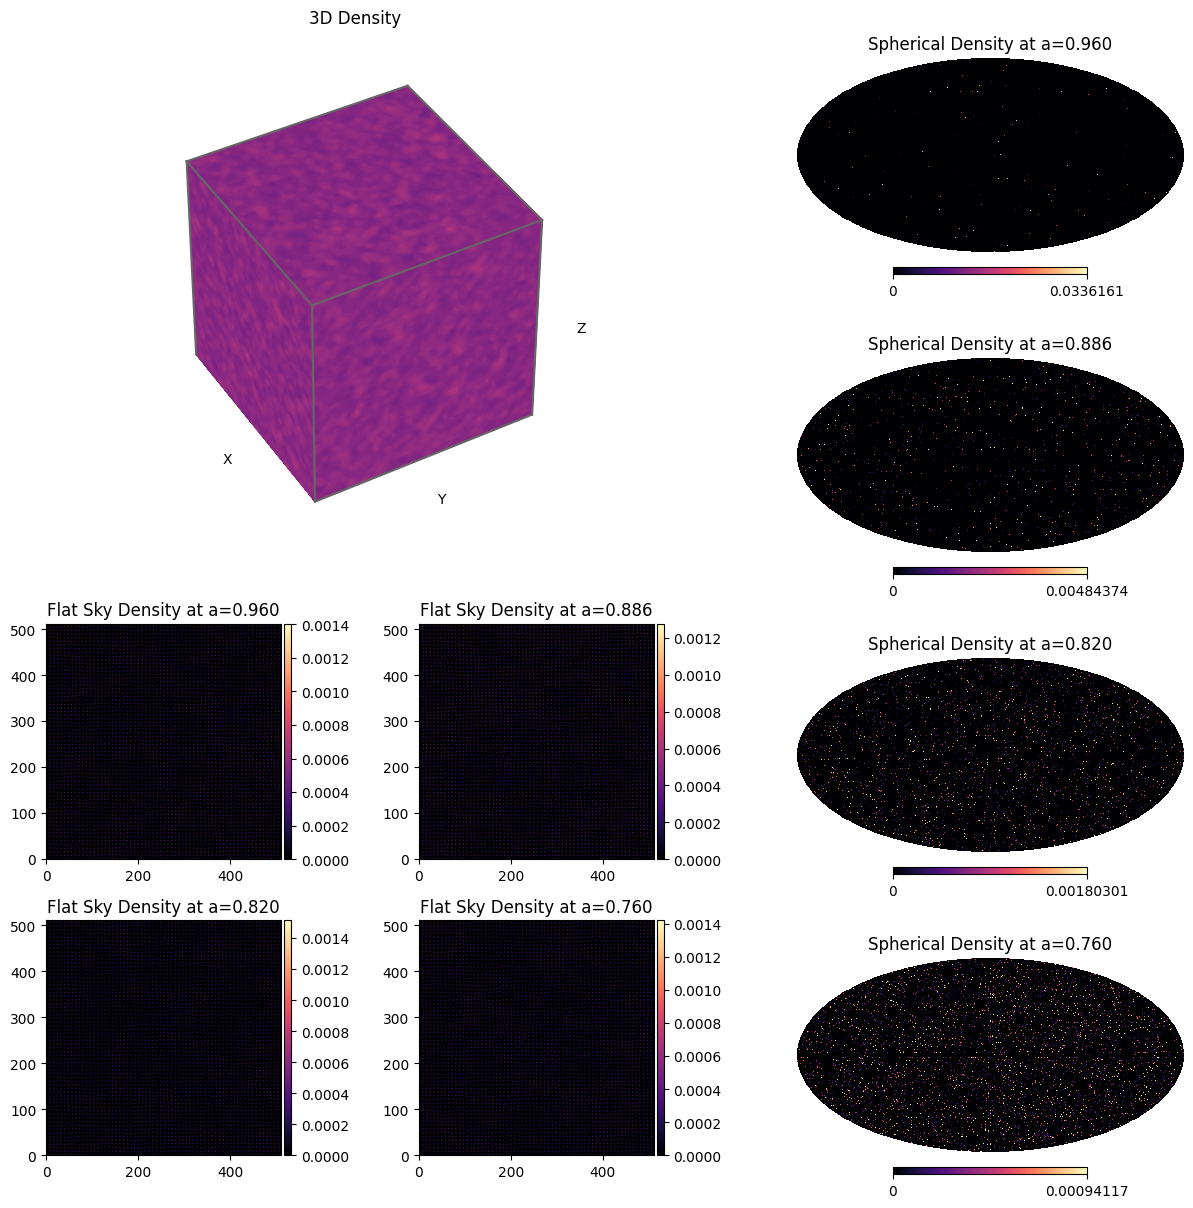

In [11]:
figure = plt.figure(figsize=(12, 12))
nb_snap = spherical_dens.shape[0]

# Create 4x3 grid
gs = figure.add_gridspec(4, 3, width_ratios=[0.8, 0.8, 1], height_ratios=[1, 1, 1, 1])

# 3D Density: 2x2 block (top-left, rows 0-1, cols 0-1)
ax_dens3d = figure.add_subplot(gs[:2, :2], projection='3d')

# Flat density: 2x2 block (bottom-left, rows 2-3, cols 0-1)
ax_flat = [
    figure.add_subplot(gs[2, 0]),  # z=0
    figure.add_subplot(gs[2, 1]),  # z=1
    figure.add_subplot(gs[3, 0]),  # z=2
    figure.add_subplot(gs[3, 1]),  # z=3
]

# Spherical: 4x1 column (right side, all 4 rows, col 2)
ax_sphere = [figure.add_subplot(gs[i, 2]) for i in range(4)]

# Plot
spherical_dens.plot(ax=ax_sphere)
flat_dens.plot(ax=ax_flat)
density3d.apply_fn(jnp.log1p).plot(ax=ax_dens3d, colorbar=False, project_slices=32)

plt.tight_layout()
plt.show()

# Compare against theory

In [12]:
from fwd_model_tools import PowerSpectrum, compute_theory_cl, tophat_z, edges

a_edges = edges(a_center)
a_near_far = jnp.stack([a_edges[1:], a_edges[:-1]], axis=-1)

z_centers = jc.utils.a2z(a_center)
z_sources = jc.utils.a2z(a_near_far)[::-1]  # Reverse because lightcones are always from observer and to a=0
z_near, z_far = z_sources[..., 0], z_sources[..., 1]
nz_s = [tophat_z(n, f, gals_per_arcmin2=1.0) for n, f in zip(z_near, z_far)]

LMAX = 3 * nside - 1
ells = jnp.arange(LMAX)
theory_cl_ps = compute_theory_cl(cosmo, ell=ells, z_source=nz_s, probe_type="number_counts", nonlinear_fn='linear', cross=False)

# Compute angular cl

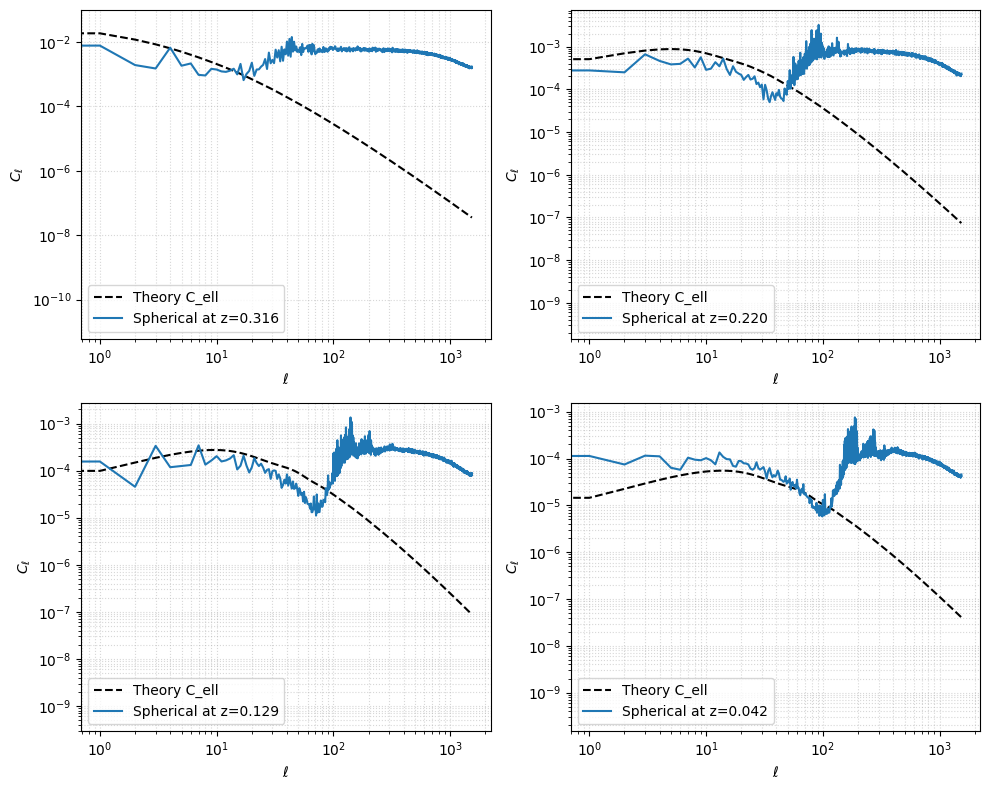

In [13]:
spherical_dens_over = spherical_dens / spherical_dens.array.mean(axis=-1)[:,None] - 1

nb_snap = spherical_dens.shape[0]

figure , axes = plt.subplots(nb_snap // 2, 2 , figsize=(10, 8))
cl_sphere = spherical_dens_over.angular_cl(method="healpy")

axes = axes.flatten()

for i in range(nb_snap):
    theory_cl_ps[i].plot(ax=axes[i] , logx=True , logy=True , label=['Theory C_ell'] , color='black' , linestyle='--' )
    cl_sphere[i].plot(ax=axes[i] , logx=True , logy=True , label=[f"Spherical at z={z_centers[i]:.3f}"])

plt.tight_layout()
plt.show()